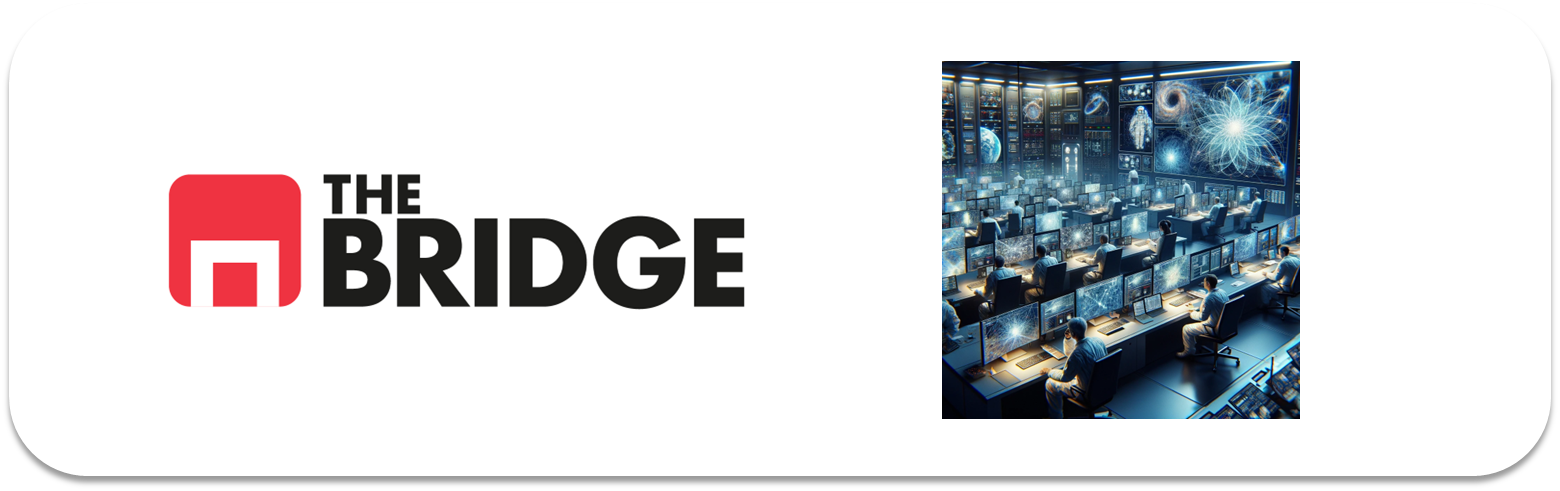

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from skimage.io import imread
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.metrics import confusion_matrix
import keras
import cv2


import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras import datasets, layers, models

2024-10-25 16:49:08.538863: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



---
1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

In [2]:
import zipfile
path_to_zip_file = "./data/seg_train.zip"
directory_to_extract_to = "./data/"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [3]:
TRAIN_PATH = './data/seg_train'

X_train = []
y_train = []

for category in os.listdir(TRAIN_PATH):
    category_path = os.path.join(TRAIN_PATH, category)
    if os.path.isdir(category_path):
        for file in os.listdir(category_path):
            file_path = os.path.join(TRAIN_PATH, category, file)
            img = plt.imread(file_path)
            img = cv2.resize(img, (64, 64))
            X_train.append(img)
            y_train.append(category)

X_train = np.array(X_train)
y_train = np.array(y_train)
print(X_train.shape)
print(y_train.shape)

(14034, 64, 64, 3)
(14034,)


In [4]:
path_to_zip_file = "./data/seg_test.zip"
directory_to_extract_to = "./data/"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

TEST_PATH = './data/seg_test'

X_test = []
y_test = []

for category in os.listdir(TEST_PATH):
    category_path = os.path.join(TEST_PATH, category)
    if os.path.isdir(category_path):
        for file in os.listdir(category_path):
            file_path = os.path.join(TEST_PATH, category, file)
            img = plt.imread(file_path)
            img = cv2.resize(img, (64, 64))
            X_test.append(img)
            y_test.append(category)

X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_test.shape)
print(y_test.shape)

(3000, 64, 64, 3)
(3000,)


In [5]:
def show_image_batch(images, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(images) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])

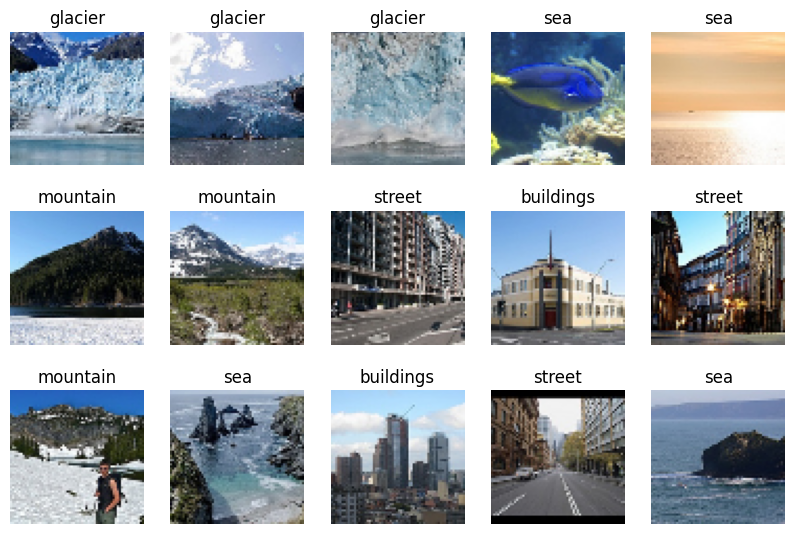

In [6]:
indices = np.random.randint(0,len(X_train),15)
show_image_batch(X_train[indices], y_train[indices])

In [7]:
pd.Series(y_train).value_counts(True)

mountain     0.178994
glacier      0.171298
street       0.169731
sea          0.162035
forest       0.161821
buildings    0.156121
dtype: float64

In [8]:
X_train = X_train/255
X_test = X_test/255

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [10]:
X_train_s, y_train_s = shuffle(X_train, y_train, random_state=42)
X_val_s, y_val_s = shuffle(X_val, y_val, random_state=42)

In [11]:
categories = np.unique(y_train)
n_categories = len(categories)

cat_map = {cat: i for i, cat in enumerate(categories)}
inverse_map = {valor:clave for clave, valor in cat_map.items()}

In [12]:
y_train_num = np.array([cat_map[cat] for cat in y_train_s])
y_test_num = np.array([cat_map[cat] for cat in y_test])

---
2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

In [13]:
from tensorflow.keras.applications import VGG19, InceptionV3, MobileNetV2

---
4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

In [14]:
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(64,64,3))

/var/folders/50/1z4vl3_96lj7wvqp_4kxvlm80000gn/T/ipykernel_5323/2743070205.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(64,64,3))


In [15]:
for layer in base_model.layers:
    layer.trainable = False

In [16]:
x = layers.Flatten()(base_model.output)

x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(len(categories), activation='softmax')(x)

In [17]:
model = models.Model(inputs=base_model.input, outputs=x)

In [18]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [19]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 32, 32,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 32, 32,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 32, 32,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 32, 32,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 32, 32,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 32, 32,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 32, 32,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 32, 32,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 33, 33,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 16, 16,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 16, 16,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 16, 16,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 16, 16,    │      2,304 │ block_1_depthwis

 Total params: 5,012,806 (19.12 MB)

 Trainable params: 2,754,822 (10.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [20]:
model.fit(X_train, y_train_num,
          validation_data=(X_val, y_val),
          epochs=10,
          batch_size=32)

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.1714 - loss: 2.0288

ValueError: Invalid dtype: str288

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_num)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

In [ ]:
y_pred = [np.argmax(pred) for pred in model.predict(X_test)]

In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [ ]:
y_test_labels = [inverse_map[y] for y in y_test_num]
y_pred_labels = [inverse_map[y] for y in y_pred]

print(classification_report(y_test_labels, y_pred_labels))

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test_labels, y_pred_labels, normalize=True)

---
5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

In [ ]:
base_model = MobileNetV2(input_shape=(64,64,3), include_top=False, weights=None, classifier_activation='softmax')

x = layers.Flatten()(base_model.output)

x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(len(categories), activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=x)

model.compile(optimizer = keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train_num,
          validation_data=(X_val, y_val),
          epochs=10,
          batch_size=32)

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_num)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

In [ ]:
y_pred = [np.argmax(pred) for pred in model.predict(X_test)]

y_test_labels = [inverse_map[y] for y in y_test_num]
y_pred_labels = [inverse_map[y] for y in y_pred]

print(classification_report(y_test_labels, y_pred_labels))

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test_labels, y_pred_labels, normalize=True)

---
6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.